In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import random
import time

In [2]:
# provide the path to your local installation of the CROPseq-multi package
CSM_dir = os.popen('git rev-parse --show-toplevel').read().strip('\n')
os.chdir(CSM_dir)
sys.path.append(CSM_dir+'/csm')

import guide_selection, barcode_selection, oligo_design

### In this simplified notebook, modify only the parameters in the following cell.

- guides should be selected using CRISPick and provided as input file
    - See: https://portals.broadinstitute.org/gppx/crispick/public
    - use "Chen (2013) tracrRNA" model for guide selection
    - design 1-2 additional sgRNAs per gene than you anticipate using
        - for example, if you will use 4 unique sgRNAs per gene, design 5-6 per gene with CRISPick.
        - the highest highest ranked guides will be prioritized.
- controls are pulled from a pre-designed set for hg38 and are only appropriate for screens in human cells
- this notebook implements reasonable and generalized best practices for guide pairing, barcode selection, tRNA selection, etc.
    - for greater customization, use the notebook "single_target_library_design.ipynb"

In [3]:
# MODIFY PARAMETERS HERE

# provide the path to the CRISPick output with your designed guides
CRISPICK_DESIGN_FILE_PATH = 'input_files/CRISPick_output_single_target_example.txt'

# indicate the desired number of constructs per gene (must provide at least 2 * N_CONSTRUCTS_PER_GENE unique guides per gene)
N_CONSTRUCTS_PER_GENE = 2

# indicate the CRISPR modality (determines which control guides to use)
MODALITY = 'CRISPRko' # 'CRISPRko', 'CRISPRi', or 'CRISPRa'

# indicate the desired number of each type of controls
# nontargeting controls (non-cutting for CRISPRko)
N_NONTARGETING_CONTROL_CONSTRUCTS = 100

# intergenic controls (cutting for CRISPRko)
N_INTERGENIC_CONTROL_CONSTRUCTS = 100

# olfactory receptor controls (gene-cutting for CRISPRko)
N_OLFACTORY_RECEPTOR_GENES = 50
N_CONSTRUCTS_PER_OLFACTORY_RECEPTOR = 2

# optionally, select a subset tRNAs to use from tRNA_A, tRNA_P, and tRNA_Q. Default is to use all three.
# please exclude 'tRNA_Q' for libraries to be handled by Broad's Genetic Perturbation Platform
use_tRNAs = [
    'tRNA_A', 
    'tRNA_P', 
    # 'tRNA_Q',
    ]

### after entering parameters above, run the following cell without modification

############## pairing gene-tareting guides ##############



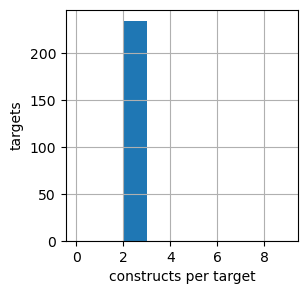

############## designing controls ##############



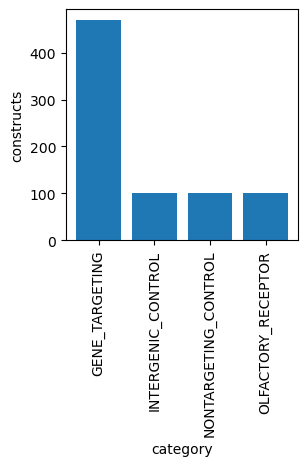

############## selecting iBARs ##############


Edit distance 3 in 9 cycles

generating and filtering complete iBARs...


100%|██████████| 3054/3054 [00:00<00:00, 38013.94it/s]



optimizing barcode pairing...
attempt 1/3


100%|██████████| 2010/2010 [00:00<00:00, 994168.75it/s]



designed 1045 barcode pairs

determining cycling requirements for decoding...

barcode 1 is unique in set(barcode 1) in:
 7 cycles

barcode 2 is unique in set(barcode 2) in:
 7 cycles

barcodes in set(barcode 1, barcode 2) are unique in:
 7 cycles

simulating recombination detection...



barcode pair is unique in set(1-2, 2-1) in :
 3 cycles with 55% recombination detection
 or:
 4 cycles with 96% recombination detection

simulating recombination detection...



barcode pair is unique in set(1-2) in:
 3 cycles with 54% recombination detection
 or:
 4 cycles with 96% recombination detection
############## designing final oligos ##############



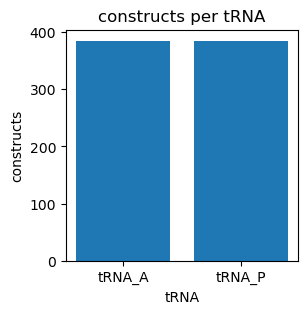

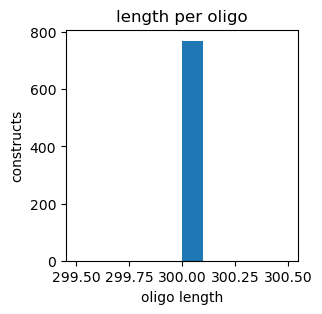

############## complete ##############

files have been saved as follows:
design file: oligo_designs/CSM_library_design.20251202-110016.csv
oligo order file: oligo_designs/CSM_oligo_order.20251202-110016.csv
GPP internal production manifest: oligo_designs/CSM_GPP_IPM.20251202-110016-6col.csv


In [ ]:
# RUN THIS CELL WITHOUT MODIFICATION

## design gene-targeting constructs
print('############## pairing gene-tareting guides ##############\n')
guide_input_df = pd.read_table(CRISPICK_DESIGN_FILE_PATH)

gene_targeting_pairs = guide_selection.pair_guides_single_target_CRISPick(
    guide_input_df, 
    constructs_per_gene = N_CONSTRUCTS_PER_GENE,
    pairing_method='pick_sum'
)

gene_targeting_pairs['category']='GENE_TARGETING'

plt.figure(figsize=(3,3))
gene_targeting_pairs.value_counts('target').hist(bins=range(0,10))
plt.xlabel('constructs per target')
plt.ylabel('targets')
plt.show()

## design controls
print('############## designing controls ##############\n')
control_pairs_df = guide_selection.pair_guides_single_target_controls(
    n_OR_genes = N_OLFACTORY_RECEPTOR_GENES, # number of olfactory receptor genes to use as controls
    n_OR_constructs_per_gene = N_CONSTRUCTS_PER_OLFACTORY_RECEPTOR, # number of constructs to design per olfactory receptor gene target
    n_intergenic_constructs = N_INTERGENIC_CONTROL_CONSTRUCTS, # number of intergenic control constructs
    n_nontargeting_constructs = N_NONTARGETING_CONTROL_CONSTRUCTS, # number of nontargeting control constructs
    modality = MODALITY,
)

# combine controls and gene-targeting
guide_pairs_df = pd.concat([ gene_targeting_pairs, control_pairs_df],
                           ignore_index=True).reset_index(drop=True)

plt.figure(figsize=(3,3))
plt.bar(guide_pairs_df.value_counts('category').index,
        guide_pairs_df.value_counts('category').values)
plt.xlabel('category')
plt.xticks(rotation=90)
plt.ylabel('constructs')
plt.show()

# import all the barcode sets
print('############## selecting iBARs ##############\n')
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

# select and pair barcodes guaranteeing all barcoedes are unique 
# and enable error correction in fewst cycles possible
library_design_df = barcode_selection.automated_iBAR_assignment(
    guide_pairs_df, 
    distance=3, 
    method='random_unique',
)

print('############## designing final oligos ##############\n')

# randomly assign tRNAs (in equal proportions)
library_design_df = oligo_design.assign_tRNAs(library_design_df, tRNAs = use_tRNAs)
oligo_design_df, df_failed = oligo_design.generate_oligos(library_design_df)

if not df_failed.empty:
    print("inspect 'df_failed' for failed oligo designs")

plt.figure(figsize=(3,3))
plt.title('constructs per tRNA')
plt.bar(oligo_design_df.value_counts('tRNA').index, oligo_design_df.value_counts('tRNA').values)
plt.xlabel('tRNA')
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.title('length per oligo')
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

## save library design

# this is the complete oligo design
design_filepath = 'oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S"))
oligo_filepath = 'oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S"))
gpp_ipm_filepath = 'oligo_designs/CSM_GPP_IPM.%s-6col.csv'%(time.strftime("%Y%m%d-%H%M%S"))

oligo_design_df.to_csv(design_filepath,index=False)

# this file can be submitted directly for ordering the oligo pool
oligo_design_df['oligo'].to_csv(oligo_filepath)

# if collaborating with Broad's GPP on library design and construction, 
# this file provides the design information for their internal record keeping
gpp_ipm = guide_selection.generate_GPP_internal_production_manifest(CRISPICK_DESIGN_FILE_PATH, oligo_design_df, MODALITY)
gpp_ipm.to_csv(gpp_ipm_filepath,index=False)

print('############## complete ##############')

print('\nfiles have been saved as follows:')
print(f'design file: {design_filepath}')
print(f'oligo order file: {oligo_filepath}')
print(f'GPP internal production manifest: {gpp_ipm_filepath}')
